In [1]:
import pandas as pd
import numpy as np
import glob
import datetime
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import emoji

# Creating DataFrame from Facebook Messages Raw Data

After downloading your messages from Facebook, you might be a little confused about it's structure. I'll try to lay it out.
1. Provide the directory to the inbox folder of your Facebook Raw Data
2. Using glob, loop through all folders, check for .json files, and add those paths

The reason we end up with a nested list is because **a single conversation can have multiple .json files**. This happens when if it's a very long conversation (only two or three of my conversations were split into multiple files). An example of that is shown through the output of the next cell.

In [108]:
#Find all .json files of messages
inbox_dir = "../messages/inbox/*" #put the path to your own data. Inside the inbox directory are lots of sub-directories, one for each chat 

# Inside inbox_dir, there are 2 folders for each group or individual chats, one for messages and one for files, like images shared.
# The following only takes the .json files.
messages_paths = []
for f in glob.glob(inbox_dir): #for each folder
    chats_json = glob.glob(f + '/*.json')
    if not chats_json:# The folders for shared media have no .json files-- ignore those
        continue
    messages_paths.append(glob.glob(f + '/*.json')) #if your conversation is longer than 10k messages, there will be multiple .json files

You likely care about the longest conversations you have. An easy, approximate way to do this (without opening them) is to sort by the file sizes. I decided I really only cared about the top 100 I talked to the most.

In [109]:
#Take the top 100 messages (lists of message files), sorted by total storage size (not number of messages). 
#Hence helper function total_size
def total_size(message_files):
    size = 0
    for file in message_files: # to combine conversation sizes for those that were split into multiple files
        size += os.path.getsize(file)
    return size
messages_paths.sort(reverse=True, key = total_size)
messages_paths = messages_paths[:100]

In [13]:
#Read .json files into python. We end up with a list of python dictionaries I think (a list per person 
#because each person's convo are split into multiple files if too long (10,000 messages per file))
#messages_paths is list of file paths for json, messages_dict are the list of lists python dictionaries

messages_dict = []
for convos in messages_paths:
    data = []
    for convo in convos:
        with open(convo) as f:
            data.append(json.load(f))
    messages_dict.append(data)

In [15]:
#split messages_dict into group convos and individual convos
individuals = [convos for convos in messages_dict if len(convos[0]['participants']) == 2]
#individuals_name is important for keeping track of whose dataframe is whose
individuals_name = [x[0]['participants'][0]['name'] for x in individuals]

#Aliasing names! for privacy. Remove as needed
aliases = []
with open('randomNames.txt') as file: 
    names = file.readlines()
    aliases = [name.rstrip('\n') for name in names]
np.random.shuffle(aliases)
individuals_name = [aliases[i] for i in range(len(individuals))]

groups = [convos for convos in messages_dict if len(convos[0]['participants']) > 2]

Cool! Now a conversation with each person is represented by a list of dictionaries. Let's take the person I talk to the most, and put it into something a little more familiar: a dataframe!

# Preprocessing Dataframe + Feature Engineering!
Now that we have a taste of what we can do, lets look at what else we can uncover.
Here's some information I'm going to extract and make explicit in the dataframe:
1. number of words in each message
2. Change timestamp into a much more useful time object
3. Whether a message is a response or followup
4. Message Sentiment!
For convenience sake, I'll also package everything into a neat function to apply for all my conversations instead of just my_dear_friend

In [102]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

sid_obj = SentimentIntensityAnalyzer()
def create_df(lst_of_dict):
    """function creates dataframe for each convo"""
    def get_message_sentiment(message):
        result = sid_obj.polarity_scores(message)
        return result['pos'] - result['neg']
    
    #if conversation split into diff json files, combine them
    all_messages = pd.concat(pd.DataFrame.from_dict(x['messages']) for x in lst_of_dict[::-1])
    all_messages['content'] = all_messages['content'].fillna('')
    
    #change weird time_stamp into usable/understandable numbers and datetime objects
    all_messages['time_stamp'] = all_messages['timestamp_ms'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
    all_messages['hour'] = all_messages['time_stamp'].dt.hour + all_messages['time_stamp'].dt.minute/60
    time_stamp_diff = all_messages['time_stamp'].diff(periods=-1)
    all_messages['response_seconds'] = time_stamp_diff.dt.microseconds/1000000 + time_stamp_diff.dt.seconds
    all_messages['response_days'] = time_stamp_diff.dt.days.fillna(0)
    
    
    all_messages['num_words'] = all_messages['content'].str.findall(r"\w+").apply(lambda x: len(x))
    all_messages['message_sentiment'] = all_messages['content'].apply(get_message_sentiment)
    
    #hashing names because subsequent rolling must take in numbers
    all_messages['name_hashed'] = all_messages['sender_name'].apply(hash)
    all_messages['reply'] = np.roll(all_messages['name_hashed'].rolling(2).apply(lambda x: int(list(x)[0] - list(x)[1])) != 0, -1)
    
    #pick out relevant columns
    final_columns = ['sender_name', 'content', 'message_sentiment', 'num_words', 'time_stamp', 
         'hour', 'reply', 'response_seconds', 'response_days', 'reactions', 'sticker', 
         'photos', 'videos', 'files', 'gifs', 'share', 'type']
    # Not columns will be the same, e.g. you won't have a gifs column for a conversation where noone sent a gif
    all_messages = all_messages[[col for col in final_columns if col in all_messages.columns]] 
    return all_messages

#create dataframe for each individual convo
individual_df = [create_df(x) for x in individuals]

Wow, that's a lot. I'll break it down into chunks. First, we turn the list of json objects into dataframe, just as before. (The following code snippets are pulled from the function above for understanding, and will not run properly)

In [36]:
#if conversation split into diff json files, combine them
all_messages = pd.concat(pd.DataFrame.from_dict(x['messages']) for x in lst_of_json[::-1])
all_messages['content'] = all_messages['content'].fillna('')

NameError: name 'lst_of_json' is not defined

Then, we'll convert timestamp_ms (milliseconds after Jan 1st, 1970) into a datetime object, which allows us to easily find differences between two times, etc. I'm also extracting the hour each message to find daily trends and the time between messages (using the handy datetime object we just created).

In [ ]:
#change weird time_stamp into usable/understandable numbers and datetime objects
all_messages['time_stamp'] = all_messages['timestamp_ms'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
all_messages['hour'] = all_messages['time_stamp'].dt.hour + all_messages['time_stamp'].dt.minute/60
time_stamp_diff = all_messages['time_stamp'].diff(periods=-1)
all_messages['response_seconds'] = time_stamp_diff.dt.microseconds/1000000 + time_stamp_diff.dt.seconds
all_messages['response_days'] = time_stamp_diff.dt.days.fillna(0)

Then we find the message sentiment. We're using the simplest method possible: every individual word has a score associated with it. For example, "happy" would be positive, "agonizing" would be negative. We create a function that provides such a score to a single message and apply it to every row (every message).

In [41]:
def get_message_sentiment(message):
    result = sid_obj.polarity_scores(message)
    return result['pos'] - result['neg']
all_messages['num_words'] = all_messages['content'].str.findall(r"\w+").apply(lambda x: len(x))
all_messages['message_sentiment'] = all_messages['content'].apply(get_message_sentiment)

NameError: name 'all_messages' is not defined

Then, we check whether a message is a a reply to the other, or just one person sending multiple messages at a time. To do this, we check whether sender of the previous message is the same. This method is a little convoluted, but we hash the sender name, and check whether back-to-back rows have the same hashed sender_name (and therefore same sender).

In [ ]:
#hashing names because subsequent rolling must take in numbers
all_messages['name_hashed'] = all_messages['sender_name'].apply(hash)
all_messages['reply'] = np.roll(all_messages['name_hashed'].rolling(2).apply(lambda x: int(list(x)[0] - list(x)[1])) != 0, -1)

Lastly, get rid of the columns we don't need! And there we have it, a cleaned dataframe with more or less all the information that you could wish for.

In [ ]:
#pick out relevant columns
final_columns = ['sender_name', 'content', 'message_sentiment', 'num_words', 'time_stamp', 
     'hour', 'reply', 'response_seconds', 'response_days', 'reactions', 'sticker', 
     'photos', 'videos', 'files', 'gifs', 'share', 'type']
# Not columns will be the same, e.g. you won't have a gifs column for a conversation where noone sent a gif
all_messages = all_messages[[col for col in final_columns if col in all_messages.columns]] 

# Exploring the Data
This is what it looks like

In [34]:
#each person is an entry in individual_df
someone = individual_df[0]

#name change for identity protection
someone.loc[someone['sender_name'] != 'Victor Jann', 'sender_name'] = individuals_name[0]
someone.sample(5, random_state=42)

,sender_name,content,message_sentiment,num_words,time_stamp,hour,reply,response_seconds,response_days,reactions,sticker,photos,videos,files,gifs,share,type
4948,Murrah,lame stuff,-0.737,2,2019-12-01 01:02:47.924,1.033333,True,0.864,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic
4875,Victor Jann,i mostly think the same,0.000,5,2020-01-16 23:28:36.061,23.466667,False,3.704,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic
9951,Victor Jann,when's ur lab?,0.000,4,2020-02-05 02:44:44.326,2.733333,False,7.923,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic
1671,Murrah,i think my license is a scam,-0.381,7,2020-03-25 20:03:08.610,20.050000,False,5.186,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic
9129,Murrah,hm ok,0.688,2,2020-03-14 15:15:31.041,15.250000,True,97.876,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic


Let's see who I talk to the most.

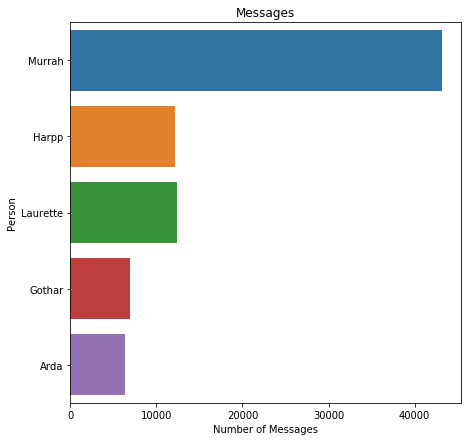

In [111]:
num_messages = [x.shape[0] for x in individual_df] #number of rows in each dataframe == number of messages
num_people_to_plot = 5
plt.figure(figsize=[7, 7])
sns.barplot(num_messages[:num_people_to_plot],individuals_name[:num_people_to_plot])
plt.title("Messages")
plt.ylabel("Person")
plt.xlabel("Number of Messages")
plt.savefig("../plots/top_friends_msg_count")

Previously, the 'message_sentiment' column is sentiment of each message. To figure out how positive each person is, we have to combine them so that each word is weighted equally. That involves multiplying sentiment by the number of words, summing
it up, and finally dividing by total number of words by that person.

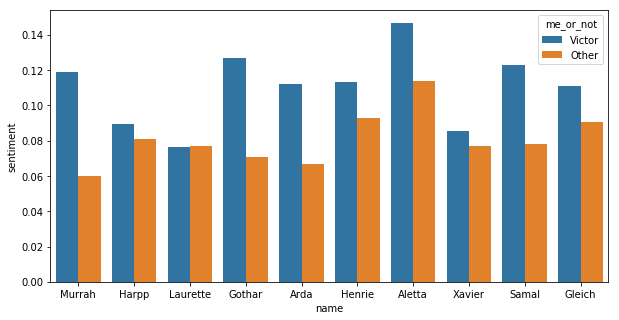

In [112]:
def determine_avg_sentiments(df):
    """returns tuple, where first item is Victor's avg sentiment, second item is the other's avg sentiment"""
    victor = df[df['sender_name'] ==  "Victor Jann"]
    not_victor = df[df['sender_name'] != "Victor Jann"]
    victor_sentiment = np.sum(victor['message_sentiment']*victor['num_words'])/np.sum(victor['num_words'])
    not_victor_sentiment = np.sum(not_victor['message_sentiment']*not_victor['num_words'])/np.sum(not_victor['num_words'])
    return (round(victor_sentiment, 4), round(not_victor_sentiment, 4))
names = []
sentiment_mine = []
sentiment_other = []
#plot for many different conversations
for i in range(10):
    other_person = individuals_name[i].split(' ')[0] #take the other person's first name
    my_sentiment, their_sentiment = determine_avg_sentiments(individual_df[i])
    names.append(other_person)
    sentiment_mine.append(my_sentiment)
    sentiment_other.append(their_sentiment)
#     print("Sentiment with {}: Victor:{}, {}:{}".format(other_person, senti_results[0], other_person, senti_results[1]))
temp = pd.DataFrame(data={'name':names, 'Victor': sentiment_mine, 'Other': sentiment_other})
temp = pd.melt(temp, id_vars='name', var_name='me_or_not', value_name='sentiment')
plt.figure(figsize=[10, 5])
sns.barplot(data=temp, x='name', y='sentiment', hue='me_or_not')


Ever wonder when is peak talking time? You can really see the difference in my sleep schedule between college and high school

[None, None]

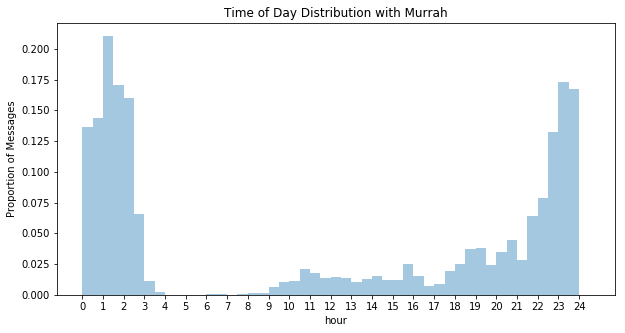

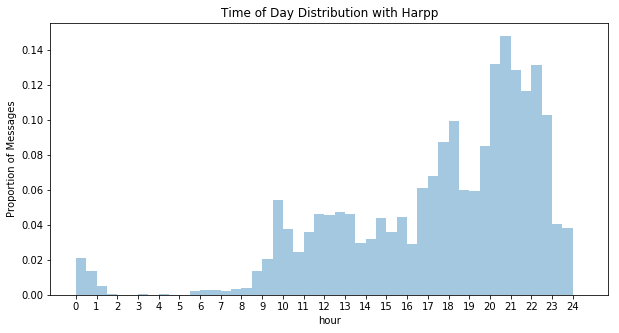

In [40]:
def plot_time_distribution(df, name):
    plt.figure(figsize=[10, 5])
    sns.distplot(df['hour'], kde=False, label = 'hi', norm_hist=True, bins=np.arange(0, 25, 0.5))
    plt.title("Time of Day Distribution with {}".format(name))
    plt.ylabel("Proportion of Messages")
    plt.xticks(np.arange(0, 25, 1))
[plot_time_distribution(individual_df[i], individuals_name[i]) for i in range(2)]

If we take another step back, we get the progression of how much you talk, every day

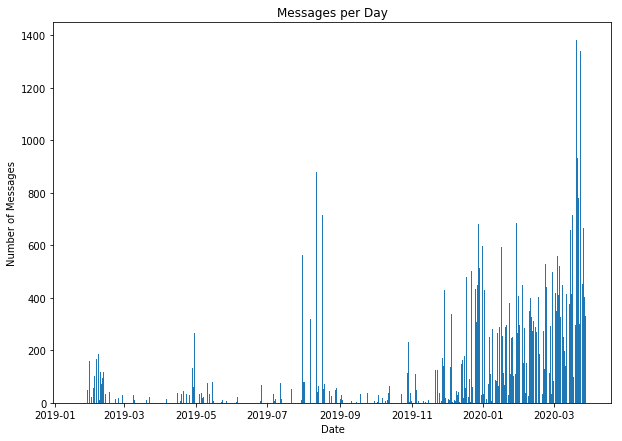

In [100]:
someone['date'] = someone['time_stamp'].dt.date
plt.figure(figsize=[10, 7])
groupby_date = someone.groupby('date').count()
plt.bar(x=groupby_date.index, height=groupby_date['content'])
plt.title("Messages per Day")
plt.ylabel("Number of Messages")
plt.xlabel("Date")
# plt.show()
plt.savefig('../plots/messages_over_time')

### How quickly do people reply? 
Luckily, we calculated most of the heavy work when creating the dataframe, so we simply use response_seconds.

[None, None]

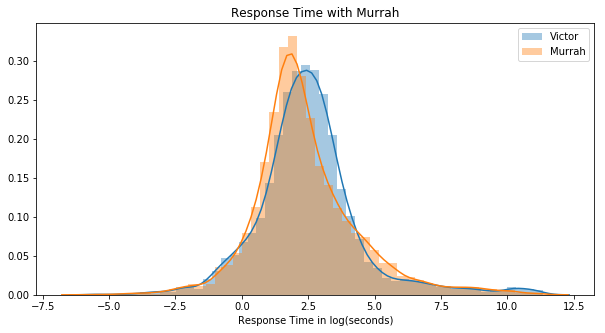

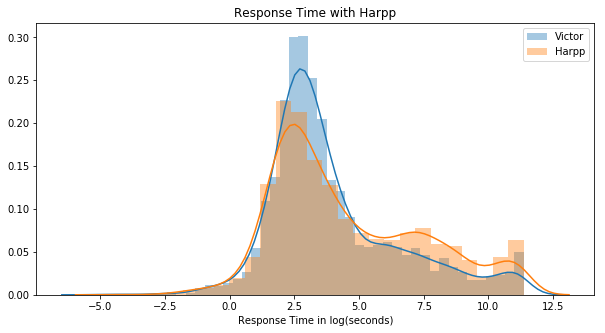

In [116]:
def plot_response_time(df, name, i):
    plt.figure(figsize=[10, 5])
    sns.distplot(np.log(df[df['reply'] & (df['sender_name'] == 'Victor Jann')]['response_seconds']).fillna(1.0), label='Victor')
    sns.distplot(np.log(df[df['reply'] & (df['sender_name'] != 'Victor Jann')]['response_seconds']).fillna(1.0), label=name)
    plt.title('Response Time with {}'.format(name))
    plt.xlabel("Response Time in log(seconds)")
    plt.legend()
#     plt.show()
    plt.savefig('../plots/response_time_distribution_' + name)
[plot_response_time(individual_df[i], individuals_name[i], i) for i in range(2)]

# Analyzing Messages with an Individual

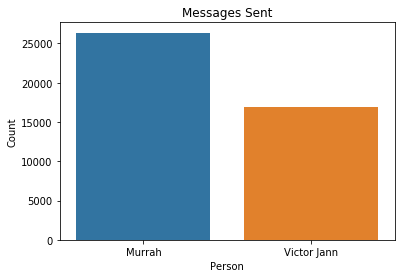

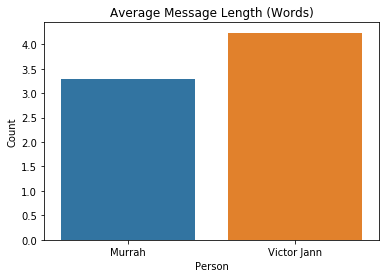

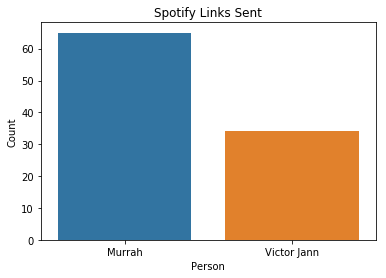

In [113]:
def plot_simple_groupings(df, title):
    plt.figure()
    sns.barplot(data=df, x=df.index, y='num_words')
    plt.title("{}".format(title))
    plt.ylabel("Count".format(title))
    plt.xlabel("Person")
#     plt.show()
    plt.savefig('../plots/simple_groupings_' + title)
messages = someone.groupby('sender_name').count()

message_len = someone.groupby('sender_name').mean()

baby_face_emoji = someone[someone['content'].str.contains("\u00f0\u009f\u00a5\u00ba")].groupby('sender_name').count() #I believe it's unicode for the 'pleading face' emoji

stickers = someone[someone['sticker'].notna()].groupby('sender_name').count()

spotify_links = someone[(someone['content'].str.contains("https://open.spotify.com/track")) | 
                       someone['share'].fillna({'link': 'dummy'}).apply(lambda x: not isinstance(x, float) and "https://open.spotify.com/track" in x['link'])]
spotify_links = spotify_links.groupby('sender_name').count()

uwus = someone[someone['content'].str.findall(r'\buwu\b').apply(lambda x: len(x) != 0)].groupby('sender_name').count()

plot_simple_groupings(messages, 'Messages Sent')
plot_simple_groupings(message_len, 'Average Message Length (Words)')
# ... keep going (or turn it into a loop)
plot_simple_groupings(spotify_links, "Spotify Links Sent")


### Word Cloud!
I found it too time-consuming to rid of the filler words, but other than that here it is!

In [114]:
#used this website https://www.geeksforgeeks.org/find-k-frequent-words-data-set-python/?ref=rp
from PIL import Image as PILImage
from collections import Counter 
from wordcloud import WordCloud, STOPWORDS

#optional add more words to ignore
more_words = []
for w in more_words:
    STOPWORDS.add(w)

np.savetxt(r'../messages/pure_message_content_vj.txt', someone[someone['sender_name'] == 'Victor Jann']['content'].values, fmt="%s")

dataset_vj = open("../messages/pure_message_content_vj.txt", "r").read().lower()

maskArray = np.array(PILImage.open("../bear.jpg"))
cloud = WordCloud(background_color = "white", max_words = 200, mask = maskArray, stopwords = set(STOPWORDS))
cloud.generate(dataset_vj)
cloud.to_file("./outputs/wordCloud_vj.png")


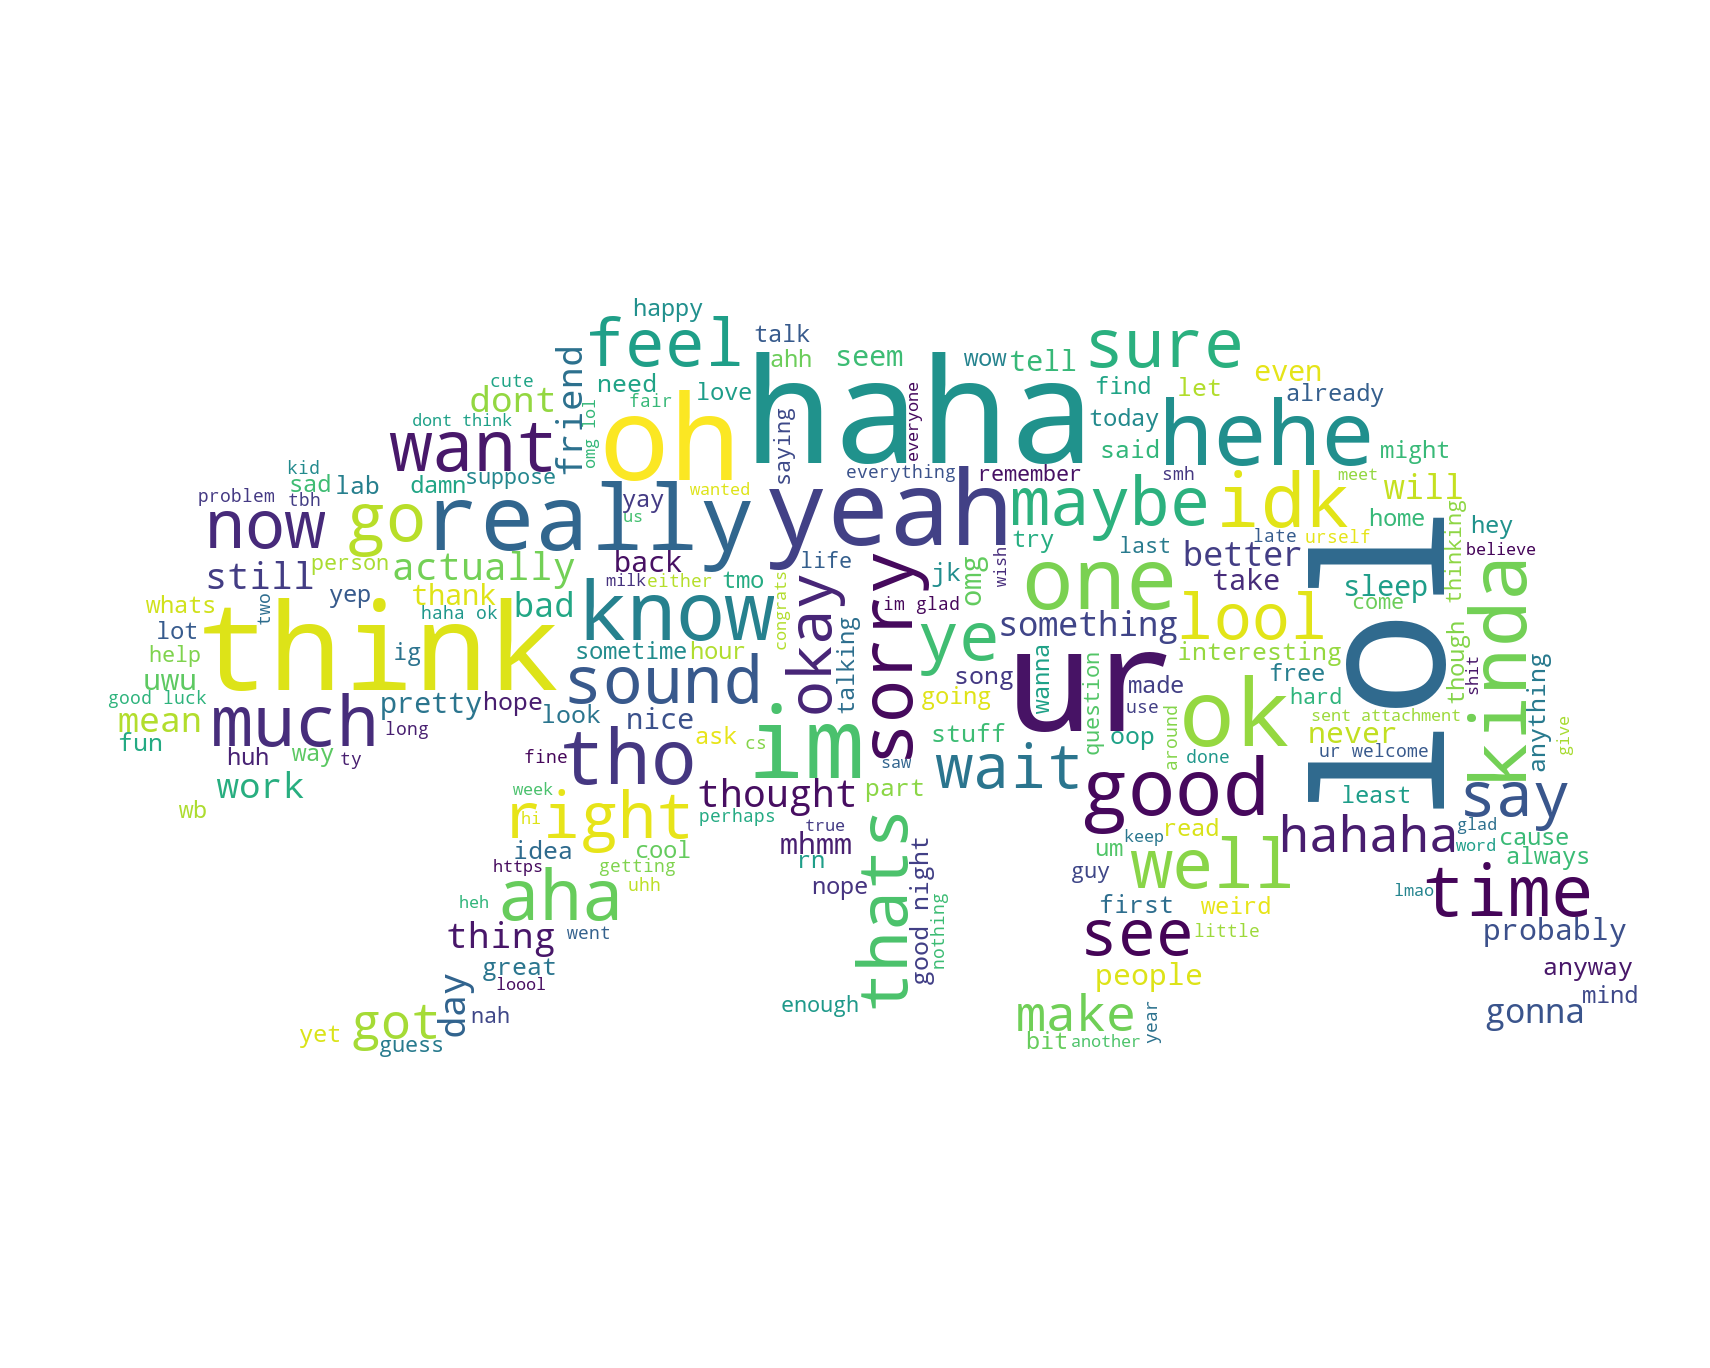

In [115]:
from IPython.display import Image as ipythonImage
ipythonImage(filename='outputs/wordCloud_vj.png') 

Lastly, here's some useful tools for finding chats at specific times or words.

In [125]:
#this is useful. find all messages in convo within "within" minutes of 'reference_date'. 
#You can add hours or days
reference_date = datetime.datetime(year=2020, month=3, day=20, hour=1, minute=24)
someone[abs(someone['time_stamp'] - reference_date) < datetime.timedelta(hours=0, minutes=0, seconds=30)]

,sender_name,content,message_sentiment,num_words,time_stamp,hour,reply,response_seconds,response_days,reactions,sticker,photos,videos,files,gifs,share,type,date
6243,Murrah,it is but i am lagging behind,-0.306,7,2020-03-20 01:24:26.123,1.400000,True,27.764,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-03-20
6244,Victor Jann,its a two person thing isnt it,0.000,7,2020-03-20 01:23:58.359,1.383333,False,6.593,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-03-20
6245,Victor Jann,LOL stop,0.232,2,2020-03-20 01:23:51.766,1.383333,True,20.413,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-03-20
6246,Murrah,im sorry,-0.565,2,2020-03-20 01:23:31.353,1.383333,False,2.660,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-03-20


In [103]:
#use regex to find all occurence of string.
someone[someone['content'].str.findall(r'go bears').apply(lambda x: len(x) != 0)].sort_values('time_stamp',ascending=False)

,sender_name,content,message_sentiment,num_words,time_stamp,hour,reply,response_seconds,response_days,reactions,sticker,photos,videos,files,gifs,share,type,date
694,Victor Jann,go bears,0.0,2,2020-03-27 14:04:57.872,14.066667,False,2.333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-03-27
5617,Victor Jann,go bears,0.0,2,2020-02-24 00:31:16.259,0.516667,False,5.779,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Generic,2020-02-24
